In [45]:
import pandas as pd
import random
import math
import numpy as np
import matplotlib.pyplot as plt

In [46]:
from pulp import *

In [47]:
original_df1 = pd.read_excel("dataset.xlsx",header=0) 

In [48]:
original_df1 = original_df1.fillna(0)

In [92]:
input_rows=len(original_df1.index)
if (input_rows > 1000):
    original_df = original_df1.sample(1000)
else:
    original_df = original_df1
data_index = original_df.index


In [93]:
original_df=original_df.reset_index(drop=True)



In [109]:

new_data_index = original_df.index
print(new_data_index)
data_tuples = list(zip(data_index,new_data_index))
match=pd.DataFrame(data_tuples, columns=['Old','New'])


RangeIndex(start=0, stop=1000, step=1)


In [95]:
productVariables = pulp.LpVariable.dicts("aliment",(product for product in original_df.index),lowBound=0,upBound = 20)

In [96]:
epsVariables = pulp.LpVariable.dicts("epsilon",(i for i in range(4)),lowBound=1,upBound = 20)

In [97]:
 
#utility 1
marginalVariables1 = pulp.LpVariable.dicts("u_1",(row for row in original_df['energy100g']),lowBound=0,upBound = 20)
 
#utility 2
marginalVariables2 = pulp.LpVariable.dicts("u_2",(row for row in original_df['saturatedfat100g']),lowBound=0,upBound = 20)
#utility 3
marginalVariables3 = pulp.LpVariable.dicts("u_3",(row for row in original_df['sugars100g']),lowBound=0,upBound = 20)
#utility 4
marginalVariables4 = pulp.LpVariable.dicts("u_4",(row for row in original_df['fiber100g']),lowBound=0,upBound = 20)
#utility 5
marginalVariables5 = pulp.LpVariable.dicts("u_5",(row for row in original_df['proteins100g']),lowBound=0,upBound = 20)
#utility 6
marginalVariables6 = pulp.LpVariable.dicts("u_6",(row for row in original_df['sodium100g']),lowBound=0,upBound = 20)


In [98]:
model = pulp.LpProblem("NutriScore",LpMaximize)

In [99]:
# objective function
model += pulp.lpSum(epsVariables)

In [100]:
#constraints associated to global utility of each food
for product in original_df.index:
    energy = original_df['energy100g'].iloc[product]
    saturatedfat = original_df['saturatedfat100g'].iloc[product]
    sugars = original_df['sugars100g'].iloc[product]
    fiber = original_df['fiber100g'].iloc[product]
    proteins = original_df['proteins100g'].iloc[product]
    sodium = original_df['sodium100g'].iloc[product]
    model += marginalVariables1[energy] + marginalVariables2[saturatedfat] + marginalVariables3[sugars] + marginalVariables4[fiber] + marginalVariables5[proteins] + marginalVariables6[sodium]  == productVariables[product]


In [101]:
# set preferences
grade_A = []
grade_B = []
grade_C = []
grade_D = []
grade_E = []
for index in range(len(original_df['nutriscoregrade'])):
    nutri_grade = original_df['nutriscoregrade'][index]
    if (nutri_grade == 'a'):
        grade_A.append(index)
    else:
        if (nutri_grade == 'b'):
            grade_B.append(index)   
        else:
            if (nutri_grade == 'c'):
                grade_C.append(index)  
            
            else:
                if (nutri_grade == 'd'):
                    grade_D.append(index)
                else:
                    if (nutri_grade == 'e'):
                        grade_E.append(index)
                        
pref_A = random.sample(grade_A, math.ceil(len(grade_A)*0.05))
pref_B = random.sample(grade_B, math.ceil(len(grade_B)*0.05))
pref_C = random.sample(grade_C, math.ceil(len(grade_C)*0.05))
pref_D = random.sample(grade_D, math.ceil(len(grade_D)*0.05))
pref_E = random.sample(grade_E, math.ceil(len(grade_E)*0.05))

In [102]:
for a in pref_A:
    for b in pref_B:
        model += productVariables[b] + epsVariables[0] <= productVariables[a]  
for b in pref_B:
    for c in pref_C:
        model += productVariables[c] + epsVariables[1] <= productVariables[b]
for c in pref_C:
    for d in pref_D:
        model += productVariables[d] + epsVariables[2] <= productVariables[c]
for d in pref_D:
    for e in pref_E:
        model += productVariables[e] + epsVariables[3] <= productVariables[d]

In [103]:
#Monotonicity constraints
energy = original_df["energy100g"].sort_values(ascending=False)
ordered1 = []
for x in energy:
    ordered1.append(marginalVariables1[x])

energy = original_df["energy100g"].sort_values(ascending=False)
ordered1 = []
for x in energy:
    ordered1.append(marginalVariables1[x])

saturatedfat = original_df["saturatedfat100g"].sort_values(ascending=False)
ordered2 = []
for x in saturatedfat:
    ordered2.append(marginalVariables2[x])
    
sugars = original_df["sugars100g"].sort_values(ascending=False)
ordered3 = []
for x in sugars:
    ordered3.append(marginalVariables3[x])

fiber = original_df["fiber100g"].sort_values(ascending=True)
ordered4 = []
for x in fiber:
    ordered4.append(marginalVariables4[x])

proteins = original_df["proteins100g"].sort_values(ascending=True)
ordered5 = []
for x in proteins:
    ordered5.append(marginalVariables5[x])
    
sodium = original_df["sodium100g"].sort_values(ascending=False)
ordered6 = []
for x in sodium:
    ordered6.append(marginalVariables6[x])





In [104]:
for i in range (len(ordered1)-1):
    model += ordered1[i] <= ordered1[i+1]
    model += ordered2[i] <= ordered2[i+1]
    model += ordered3[i] <= ordered3[i+1]
    model += ordered4[i] <= ordered4[i+1]
    model += ordered5[i] <= ordered5[i+1]
    model += ordered6[i] <= ordered6[i+1]
    

In [105]:
model.solve()

status = LpStatus[model.status]
print(status)

Optimal


In [106]:
for v in model.variables():
    print(v.name, "=", v.varValue)


# The optimised objective function value is printed to the screen
print("Value of objectiove function = ", value(model.objective))

aliment_0 = 11.47619
aliment_1 = 12.666667
aliment_10 = 18.857143
aliment_100 = 12.714286
aliment_101 = 10.238095
aliment_102 = 12.142857
aliment_103 = 10.380952
aliment_104 = 10.380952
aliment_105 = 14.857143
aliment_106 = 11.333333
aliment_107 = 14.333333
aliment_108 = 12.142857
aliment_109 = 13.190476
aliment_11 = 11.142857
aliment_110 = 10.714286
aliment_111 = 11.47619
aliment_112 = 15.952381
aliment_113 = 12.809524
aliment_114 = 12.285714
aliment_115 = 10.809524
aliment_116 = 10.52381
aliment_117 = 13.904762
aliment_118 = 10.952381
aliment_119 = 13.238095
aliment_12 = 18.428571
aliment_120 = 10.380952
aliment_121 = 15.333333
aliment_122 = 10.380952
aliment_123 = 12.285714
aliment_124 = 11.47619
aliment_125 = 11.285714
aliment_126 = 12.095238
aliment_127 = 14.952381
aliment_128 = 16.142857
aliment_129 = 8.2380952
aliment_13 = 12.238095
aliment_130 = 20.0
aliment_131 = 17.52381
aliment_132 = 12.190476
aliment_133 = 16.904762
aliment_134 = 9.0
aliment_135 = 14.952381
aliment_136 = 6.

In [107]:
original_df1['index1'] = original_df1.index

In [110]:
merged = pd.merge(match, original_df1, left_on='Old', right_on='index1', how='left').drop('index1', axis=1)

In [111]:
merged_mod = merged.drop(['Old'], axis=1)
merged_mod = merged_mod.drop(['New'], axis=1)
o_df_mod = original_df1.drop(['index1'],axis=1)


In [112]:
unlabeled = pd.concat([o_df_mod,merged_mod]).drop_duplicates(keep=False)
unlabeled_rows = len(unlabeled.index)
print(unlabeled_rows)

4223


In [114]:

scores = np.zeros(1000)
new_nutri_grade = [''] * 1000
utility1={}
utility2={}
utility3={}
utility4={}
utility5={}
utility6={}
for v in model.variables():
    v_name=v.name.split("_")
    if(v_name[0] == 'aliment'):
        i = int(v_name[1])
        scores[i] = v.varValue
        if (v.varValue >= 17):
            new_nutri_grade[i] = 'a'
        else:
            if (v.varValue >= 13):
                new_nutri_grade[i] = 'b'
            else:
                if (v.varValue >= 9):
                    new_nutri_grade[i] = 'c'
                else:
                    if (v.varValue >= 5):
                        new_nutri_grade[i] = 'd'
                    else:
                        new_nutri_grade[i] = 'e'
    else:
        if (v_name[0]=='u'):
            # utility variables
            u = v_name[1]
            u_val = v_name[2]
            if (u == '1'):
                utility1[u_val]= v.varValue
            else:
                if (u =='2'):
                    utility2[u_val]= v.varValue
                else:
                    if(u=='3'):
                        utility3[u_val]= v.varValue
                    else:
                        if (u=='4'):
                            utility4[u_val]= v.varValue
                        else: 
                            if (u =='5'):
                                utility5[u_val]= v.varValue
                            else:
                                if (u=='6'):
                                    utility6[u_val]= v.varValue
         

In [115]:
merged['new_scores']=scores

In [116]:
merged['new_nutri_grades']=new_nutri_grade

In [117]:
merged_u1 = []
merged_u2 = []
merged_u3 = []
merged_u4 = []
merged_u5 = []
merged_u6 = []
for e in merged['energy100g']:
    x=utility1.get(str(e),0)
    merged_u1.append(x)
    
for f in merged['saturatedfat100g']:
    x=utility2.get(str(f),0)
    merged_u2.append(x)
        
for s in merged['sugars100g']:
    x=utility3.get(str(s),0)
    merged_u3.append(x)

for fb in merged['fiber100g']:
    x=utility4.get(str(fb),0)
    merged_u4.append(x)
        
for p in merged['proteins100g']:
    x=utility5.get(str(p),0)
    merged_u5.append(x)

for sd in merged['sodium100g']:
    x=utility6.get(str(sd),0)
    merged_u6.append(x)


In [118]:
merged['utility_1']=merged_u1
merged['utility_2']=merged_u2
merged['utility_3']=merged_u3
merged['utility_4']=merged_u4
merged['utility_5']=merged_u5
merged['utility_6']=merged_u6


In [119]:
#confusion_matrix

CF = {'a':{'a':0,'b':0,'c':0,'d':0,'e':0},
    'b':{'a':0,'b':0,'c':0,'d':0,'e':0},
    'c':{'a':0,'b':0,'c':0,'d':0,'e':0},
    'd':{'a':0,'b':0,'c':0,'d':0,'e':0},
    'e':{'a':0,'b':0,'c':0,'d':0,'e':0}}

In [120]:
merged = merged.fillna(0)
for index, row in merged.iterrows():
    if (row['nutriscoregrade'] == 0 or row['new_nutri_grades'] == 0):
        continue
    else:
        CF[row['nutriscoregrade']][row['new_nutri_grades']] += 1


In [122]:
#calculation precision, recall, F-measure
FP = {'a':0,'b':0,'c':0,'d':0,'e':0}
TP = {'a':0,'b':0,'c':0,'d':0,'e':0}
FN = {'a':0,'b':0,'c':0,'d':0,'e':0}

for i in CF:
    for j in CF[i]:
        if i == j:
            TP[i] = CF[i][j]
        else:
            FP[i] += CF[i][j]
            FN[j] += CF[i][j]
            
Prec = {'a':0,'b':0,'c':0,'d':0,'e':0}
Rec = {'a':0,'b':0,'c':0,'d':0,'e':0}
F1 = {'a':0,'b':0,'c':0,'d':0,'e':0}

for i in Prec:
    Prec[i] = TP[i] / (TP[i] + FP[i])
    Rec[i] = TP[i] / (TP[i] + FN[i])
    F1[i] = 2 * Prec[i] * Rec[i] / (Prec[i] + Rec[i])

print("Confusion Matrix",CF)
print("False positives",FP)
print("False negatives",FN)
print("True positives",TP)
print("Presision", Prec)
print("Recall",Rec)
print("F1",F1)


Confusion Matrix {'a': {'a': 107, 'b': 58, 'c': 14, 'd': 0, 'e': 0}, 'b': {'a': 6, 'b': 129, 'c': 6, 'd': 0, 'e': 0}, 'c': {'a': 0, 'b': 161, 'c': 45, 'd': 14, 'e': 0}, 'd': {'a': 0, 'b': 70, 'c': 191, 'd': 21, 'e': 1}, 'e': {'a': 0, 'b': 7, 'c': 153, 'd': 15, 'e': 1}}
False positives {'a': 72, 'b': 12, 'c': 175, 'd': 262, 'e': 175}
False negatives {'a': 6, 'b': 296, 'c': 364, 'd': 29, 'e': 1}
True positives {'a': 107, 'b': 129, 'c': 45, 'd': 21, 'e': 1}
Presision {'a': 0.5977653631284916, 'b': 0.9148936170212766, 'c': 0.20454545454545456, 'd': 0.07420494699646643, 'e': 0.005681818181818182}
Recall {'a': 0.9469026548672567, 'b': 0.3035294117647059, 'c': 0.1100244498777506, 'd': 0.42, 'e': 0.5}
F1 {'a': 0.7328767123287672, 'b': 0.45583038869257947, 'c': 0.14308426073131955, 'd': 0.12612612612612611, 'e': 0.011235955056179775}


In [127]:
merged.to_csv('model_results.csv',index=False)

In [123]:
#calculate Eucledian distance
def distance(x,y):
    dist = np.sqrt(np.sum([(a-b)*(a-b) for a, b in zip(x, y)]))  
    return dist

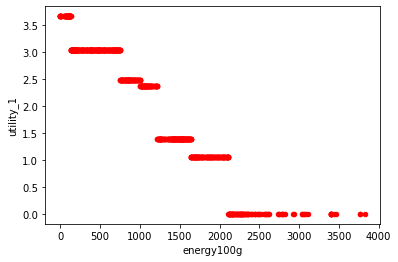

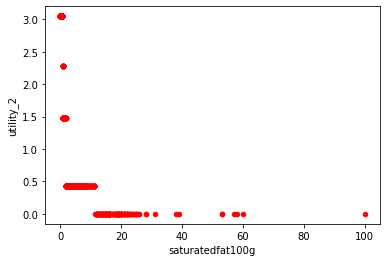

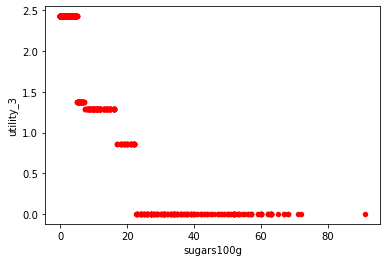

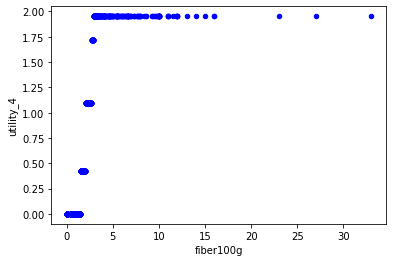

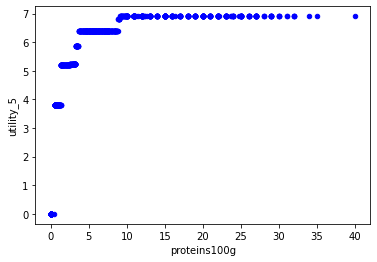

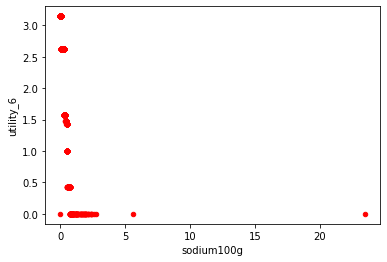

In [124]:
merged.plot(kind='scatter',x='energy100g',y='utility_1',color='red')
plt.show()
merged.plot(kind='scatter',x='saturatedfat100g',y='utility_2',color='red')
plt.show()
merged.plot(kind='scatter',x='sugars100g',y='utility_3',color='red')
plt.show()
merged.plot(kind='scatter',x='fiber100g',y='utility_4',color='blue')
plt.show()
merged.plot(kind='scatter',x='proteins100g',y='utility_5',color='blue')
plt.show()
merged.plot(kind='scatter',x='sodium100g',y='utility_6',color='red')
plt.show()


In [125]:
unlabeled = unlabeled.reset_index()

In [126]:

max_dist  = [10000000000000] * unlabeled_rows
labels  = [-1] * unlabeled_rows
for index, row in unlabeled.iterrows():
    x = pd.Series([row['energy100g'],row['saturatedfat100g'],row['sugars100g'],row['fiber100g'],row['proteins100g'],row['sodium100g']])
    for i, m_row in merged.iterrows():
        y = pd.Series([m_row['energy100g'],m_row['saturatedfat100g'],m_row['sugars100g'],m_row['fiber100g'],m_row['proteins100g'],m_row['sodium100g']])
        dist = distance(x,y)
        if (max_dist[index]>=dist):
            max_dist[index]=dist
            labels[index]=m_row['new_nutri_grades']

print(labels)
            
            


['b', 'c', 'b', 'c', 'a', 'b', 'c', 'c', 'c', 'b', 'b', 'c', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'b', 'b', 'b', 'b', 'b', 'c', 'b', 'd', 'c', 'c', 'b', 'b', 'b', 'b', 'c', 'b', 'c', 'b', 'b', 'a', 'c', 'b', 'b', 'b', 'a', 'b', 'c', 'c', 'b', 'b', 'b', 'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'b', 'a', 'b', 'b', 'b', 'c', 'b', 'c', 'b', 'c', 'b', 'b', 'a', 'b', 'b', 'b', 'b', 'b', 'c', 'b', 'c', 'c', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'b', 'b', 'b', 'a', 'c', 'c', 'c', 'b', 'c', 'c', 'b', 'c', 'b', 'c', 'c', 'c', 'b', 'b', 'c', 'b', 'c', 'c', 'b', 'b', 'b', 'd', 'b', 'c', 'b', 'b', 'a', 'b', 'c', 'a', 'b', 'b', 'd', 'b', 'a', 'c', 'c', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'a', 'c', 'a', 'c', 'b', 'b', 'c', 'a', 'b', 'b', 'c', 'b', 'd', 'b', 'b', 'b', 'a', 'b', 'c', 'c', 'd', 'c', 'd', 'c', 'c', 'c', 'c', 'b', 'b', 'a', 'd', 'c', 'c', 'a', 'b', 'b', 'c', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'b', 'b', 'a', 'c', 'c', 'c', 'b', 'c', 'b', 'a', 'c', 'c', 'a', 'b', 'b', 'a', 'b',

In [128]:
unlabeled['new_nutri_grade']=labels

In [129]:
unlabeled.to_csv('label_prediction.csv',index=False)

In [130]:
#confusion_matrix

CF2 = {'a':{'a':0,'b':0,'c':0,'d':0,'e':0},
    'b':{'a':0,'b':0,'c':0,'d':0,'e':0},
    'c':{'a':0,'b':0,'c':0,'d':0,'e':0},
    'd':{'a':0,'b':0,'c':0,'d':0,'e':0},
    'e':{'a':0,'b':0,'c':0,'d':0,'e':0}}

In [131]:
unlabeled = unlabeled.fillna(0)
for index, row in unlabeled.iterrows():
    if (row['nutriscoregrade'] == 0 or row['new_nutri_grade'] == -1):
        continue
    else:
        CF2[row['nutriscoregrade']][row['new_nutri_grade']] += 1

In [132]:
#calculation precision, recall, F-measure
FP2 = {'a':0,'b':0,'c':0,'d':0,'e':0}
TP2 = {'a':0,'b':0,'c':0,'d':0,'e':0}
FN2 = {'a':0,'b':0,'c':0,'d':0,'e':0}

for i in CF2:
    for j in CF2[i]:
        if i == j:
            TP2[i] = CF2[i][j]
        else:
            FP2[i] += CF2[i][j]
            FN2[j] += CF2[i][j]
            
Prec2 = {'a':0,'b':0,'c':0,'d':0,'e':0}
Rec2 = {'a':0,'b':0,'c':0,'d':0,'e':0}
F12 = {'a':0,'b':0,'c':0,'d':0,'e':0}

for i in Prec2:
    if (TP2[i] + FP2[i] == 0):
       Prec2[i] = float('-inf')
    else:
       Prec2[i] = TP2[i] / (TP2[i] + FP2[i])
       
    if (TP2[i] + FN2[i] == 0):
       Rec2[i] = float('-inf')
    else:
       Rec2[i] = TP2[i] / (TP2[i] + FN2[i])
    if (Prec2[i] + Rec2[i] == 0):
        F12[i]=float('-inf')
    else:
        F12[i] = 2 * Prec2[i] * Rec2[i] / (Prec2[i] + Rec2[i])


print(Prec2)

{'a': 0.3148831488314883, 'b': 0.6848, 'c': 0.268018018018018, 'd': 0.0627208480565371, 'e': 0.00130718954248366}


In [133]:
print("Confusion Matrix",CF2)
print("False positives",FP2)
print("False negatives",FN2)
print("True positives",TP2)
print("Presision", Prec2)
print("Recall",Rec2)
print("F1",F12)

Confusion Matrix {'a': {'a': 256, 'b': 424, 'c': 128, 'd': 5, 'e': 0}, 'b': {'a': 77, 'b': 428, 'c': 115, 'd': 5, 'e': 0}, 'c': {'a': 57, 'b': 542, 'c': 238, 'd': 50, 'e': 1}, 'd': {'a': 37, 'b': 434, 'c': 589, 'd': 71, 'e': 1}, 'e': {'a': 3, 'b': 99, 'c': 633, 'd': 29, 'e': 1}}
False positives {'a': 557, 'b': 197, 'c': 650, 'd': 1061, 'e': 764}
False negatives {'a': 174, 'b': 1499, 'c': 1465, 'd': 89, 'e': 2}
True positives {'a': 256, 'b': 428, 'c': 238, 'd': 71, 'e': 1}
Presision {'a': 0.3148831488314883, 'b': 0.6848, 'c': 0.268018018018018, 'd': 0.0627208480565371, 'e': 0.00130718954248366}
Recall {'a': 0.5953488372093023, 'b': 0.22210690192008303, 'c': 0.13975337639459776, 'd': 0.44375, 'e': 0.3333333333333333}
F1 {'a': 0.4119066773934031, 'b': 0.335423197492163, 'c': 0.1837128521806252, 'd': 0.10990712074303405, 'e': 0.0026041666666666665}
